#### 1. Define Material Paramaters

##### In the code below example values of materials are used but these can be changed 

a_micron & T_Kelvin = example values to vary     
gamma_val & sigma_val = properties of materials used in the paper


In [92]:
import numpy as np
import tidy3d as td
import scipy.constants as sc
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt
import os # Import the os module

"""The code generates "noise" that represents thermal flucations, then feeds it 
into tidy3d to simulate the resulting thermal emission"""


# --- 1. Define Material Parameters ---
hbar = sc.hbar # Reduced Planck's constant (constnat used in quantum mechanics)
k_B = sc.Boltzmann # Boltzmann constant (used in statistical mechanics)
c0 = sc.c # Speed of light

# Example Material Parameters (as derived from papers, scaled by a_micron)
a_micron = 1.0e-6 # Characteristic length in meters (unit cell)
gamma_val = 0.3 * (2 * np.pi * c0 / a_micron) # s^-1 (dampning rate of the system)
sigma_val = 10 * (4 * np.pi**2 * c0**2 / a_micron**2) # s^-2 (polarization response of the system)

T_kelvin = 300.0 # Absolute temperature in Kelvin (Temperature of the system)

print(f"Material Parameters:")
print(f"  Gamma: {gamma_val:.2e} s^-1")
print(f"  Sigma: {sigma_val:.2e} s^-2")
print(f"  Temperature: {T_kelvin} K")
print("-" * 30)

Material Parameters:
  Gamma: 5.65e+14 s^-1
  Sigma: 3.55e+31 s^-2
  Temperature: 300.0 K
------------------------------


#### 2. Simulation Grid and Time steps

Thought process to select Yee cell size and the time steps is using `a_micron` as a reference length and also making sure to satsify the CFL condition:

**Courant-Friedrichs-Lewy (CFL) Condition (for 3D with uniform grid steps $\Delta x, \Delta y, \Delta z$):**

$$c_{max} \cdot \Delta t \cdot \sqrt{\frac{1}{(\Delta x)^2} + \frac{1}{(\Delta y)^2} + \frac{1}{(\Delta z)^2}} \le 1$$

Where:
* $c_{max}$: The maximum speed of light in the simulation domain (typically the speed of light in vacuum, $c_0$).
* $\Delta t$: The time step (temporal resolution).
* $\Delta x, \Delta y, \Delta z$: The spatial grid cell sizes along the x, y, and z axes, respectively.


In [93]:


dt = 0.05e-15 # seconds (s) - Tidy3D uses seconds for time
N_time_steps = 2**10 # Number of time steps (reduced for faster computation/FFT)

#10 Yee cells per a_micron using a_micron as a characteristic length.
dx_m = 0.1e-6  # meters - Tidy3D uses microns for length
dy_m = 0.1e-6
dz_m = 0.1e-6

Nx_source = 5 # Number of grid points in x-direction
Ny_source = 5 # Number of grid points in y-direction
Nz_source = 5 # Number of grid points in z-direction

DeltaV = dx_m * dy_m * dz_m # m^3

print(f"Simulation Parameters:")
print(f"  Time step (dt): {dt*1e15:.2f} fs")
print(f"  Number of time steps: {N_time_steps}")
print(f"  Spatial step (dx,dy,dz): {dx_m*1e6:.2f} um")
print(f"  Source volume (DeltaV): {DeltaV:.2e} m^3")
print("-" * 30)

Simulation Parameters:
  Time step (dt): 0.05 fs
  Number of time steps: 1024
  Spatial step (dx,dy,dz): 0.10 um
  Source volume (DeltaV): 1.00e-21 m^3
------------------------------


#### 3. Calibration step

The generation of random current K' involves a normalization for emissivity calculations, which introduces a system-dependent constant. This constant accounts for the discrete nature of the FDTD grid. 

##### Standard Deviation of Random Term ($K'_{stdev}$):

* **Standard Deviation ($K'_{stdev}$):**
    * [cite_start]**Formula:** The variance of the normalized random term $K'_{i}(r,t)$ is given by $\langle|K_{i}^{\prime}(r,t)|^{2}\rangle=\frac{4\pi^{2}{C^{\prime}}^{2}}{N\Delta V}\sigma\gamma$
        Therefore, the standard deviation is the square root of this variance:
        $$K'_{stdev} = \sqrt{\frac{4\pi^{2}{C^{\prime}}^{2}}{N\Delta V}\sigma\gamma}$$
        *(Note: In the code,  `N_time_steps` for `N` and `DeltaV` for $\Delta V$)*.
    * **Variable:** `K_prime_stdev` in the code.

We must calibrate C later...

In [94]:
C_prime_squared_calibrated = 1.0e-12 # Placeholder calibration constant (needs to be calibrated)

K_prime_stdev = np.sqrt(sigma_val * gamma_val * N_time_steps * DeltaV / (4 * np.pi**2 * C_prime_squared_calibrated))
print(f"Calculated K_prime_stdev (uncalibrated): {K_prime_stdev:.2e}")
print("-" * 30)

Calculated K_prime_stdev (uncalibrated): 2.28e+19
------------------------------


#### 4. Generate Time-Domain Noise (K')

In [95]:
# Generate random numbers for all spatial points and components at once
# A 4-dimensional array is created to hold the noise values for Ex, Ey, and Ez
k_prime_time_domain = {
    'Ex': np.random.normal(loc=0, scale=K_prime_stdev, size=(Nx_source, Ny_source, Nz_source, N_time_steps)),
    'Ey': np.random.normal(loc=0, scale=K_prime_stdev, size=(Nx_source, Ny_source, Nz_source, N_time_steps)),
    'Ez': np.random.normal(loc=0, scale=K_prime_stdev, size=(Nx_source, Ny_source, Nz_source, N_time_steps))
}

print(f"Generated {N_time_steps} time steps of K' noise for {Nx_source*Ny_source*Nz_source} spatial points.")
print("-" * 30)

Generated 1024 time steps of K' noise for 125 spatial points.
------------------------------


#### 5. Fourier Transform to Frequency Domain 

This section converts the randomly generated time-domain thermal fluctuations (K') into their frequency-domain representation (J_fluct), which will then be used as the source in the Tidy3D simulation



The transfer function $H(\omega) = \frac{i\omega}{\omega^2 + i\gamma\omega}$ is used to relate the random noise term $K$ to the fluctuating current density $J_{fluct}$.

* [cite_start]**Chan et al.[cite: 1]:** The formula is explicitly stated in the paper.

    * [cite_start]"We also assume that the noise is added to the displacement field $Q$. It can be shown that adding the randomness to the free current density $J$ or to the polarization $P$ yields exactly the same results. The relation between $J$ and $Q$ is $J = \frac{1}{4\pi}\frac{\partial Q}{\partial t}$[cite: 1, 36, 143, 150]. In the frequency domain, it reads $J(\omega) = -i\omega Q(\omega)/4\pi$. [cite_start]The displacement field is related to the noise term $K$ by $Q(r,\omega)\equiv\frac{4\pi K(r,\omega)}{\omega_{0}^{2}-\omega^{2}-i\gamma\omega}$[cite: 1, 35, 142]. In the case of metals $\omega_0=0$ and we obtain:

        $$J(\omega) = \frac{i\omega K(r,\omega)}{\omega^{2}+i\gamma\omega} = K(r,\omega)H(\omega)$$

        where

        [cite_start]$$H(\omega) = \frac{i\omega}{\omega^{2}+i\gamma\omega}$$" [cite: 1, 36]

* [cite_start]**Luo et al.[cite: 115]:** The same formula is also presented.

    * "In the frequency domain, the fluctuating free-current density $J$ is thus related to $K$ by

        $$J(\omega) = \frac{i\omega K(r,\omega)}{\omega^{2}+i\gamma\omega} = K(r,\omega)H(\omega)$$

        where

        [cite_start]$$H(\omega) = \frac{i\omega}{\omega^{2}+i\gamma\omega}$$" [cite: 115, 167]

[cite_start]This transfer function, $H(\omega)$, describes how the material's properties (specifically the damping constant $\gamma$) influence the conversion of the random thermal fluctuations ($K$) into the fluctuating current density ($J$) that ultimately drives the thermal emission. [cite: 1, 36, 115, 167]

In [96]:
sampling_freq = 1.0 / dt # Hz (the number of samples per second)
freqs = fftfreq(N_time_steps, dt) # Frequencies in Hz (from numpy)
omega_vals = 2 * np.pi * freqs # Angular frequencies in rad/s

# Transfer function H(ω) = iω / (ω^2 + iγω) that relates K to J_fluct
transfer_function = np.zeros_like(omega_vals, dtype=np.complex128)
non_zero_omega_indices = np.where(omega_vals != 0)
transfer_function[non_zero_omega_indices] = (
    1j * omega_vals[non_zero_omega_indices] /
    (omega_vals[non_zero_omega_indices]**2 + 1j * gamma_val * omega_vals[non_zero_omega_indices])
)

# Initialize dictionary to store frequency-domain J_fluctuations
j_fluct_freq_domain = {
    'Ex': np.zeros_like(k_prime_time_domain['Ex'], dtype=np.complex128),
    'Ey': np.zeros_like(k_prime_time_domain['Ey'], dtype=np.complex128),
    'Ez': np.zeros_like(k_prime_time_domain['Ez'], dtype=np.complex128)
}


# Perform FFT and apply the transfer function for each spatial point and component
# This block iterates through every discrete spatial point within your defined current source volume
# and processes the time-domain random noise (K') into frequency-domain current densities (J_fluct).
for i in range(Nx_source):
    for j in range(Ny_source):
        for k in range(Nz_source):
            # For every electric field component (Ex, Ey, Ez), perform FFT and apply transfer function
            # for a given spatial point along the whole time series.
            # The ":" in the last index indicates that we are processing all time steps for that spatial point as the last dimension is time
            for comp in ['Ex', 'Ey', 'Ez']:
                fft_data = fft(k_prime_time_domain[comp][i,j,k,:])
                j_fluct_freq_domain[comp][i,j,k,:] = fft_data * transfer_function

print(f"Performed FFT and applied transfer function to K' to get J_fluct.")
print("-" * 30)

Performed FFT and applied transfer function to K' to get J_fluct.
------------------------------


#### 6. Construct Field dataset for full range (for plotting / reference)

Code block below carries out error validation and extracts values that meet the plotting criteria (valid frequencies) and inserts the frequencies into a `td.FieldDataset` object.  
The `td.FieldDataset

In [97]:
# Tidy3D uses microns for length

# Convert spatial coordinates to microns for Tidy3D
x_coords_um = np.arange(Nx_source) * dx_m * 1e6
y_coords_um = np.arange(Ny_source) * dy_m * 1e6
z_coords_um = np.arange(Nz_source) * dz_m * 1e6

# Tidy3D uses Hertz for frequency
# Select only strictly positive frequencies (exclude 0 Hz DC component)
positive_freq_mask = freqs > 0
frequencies_Hz_positive = freqs[positive_freq_mask] # These are directly in Hz

# Define our overall frequency range of interest for plotting/analysis (e.g., optical/IR range)
# These are still defined in THz for human readability, but will be converted to Hz for masking
MIN_FREQ_THZ_PLOT = 1.0   # e.g., 1 THz
MAX_FREQ_THZ_PLOT = 1000.0 # e.g., 1000 THz

# Filter frequencies to be within the desired plotting range (in Hz)
valid_freq_mask_plot = (frequencies_Hz_positive >= MIN_FREQ_THZ_PLOT * 1e12) & \
                       (frequencies_Hz_positive <= MAX_FREQ_THZ_PLOT * 1e12)

# Handle cases where `valid_freq_mask_plot` might be empty (e.g., if chosen range is outside data)
if not np.any(valid_freq_mask_plot):
    print(f"WARNING: The plotting frequency range [{MIN_FREQ_THZ_PLOT}-{MAX_FREQ_THZ_PLOT}] THz resulted in no valid frequencies from the FFT output.")
    print("Using all available positive frequencies for plotting. Consider adjusting MIN/MAX_FREQ_THZ_PLOT.")
    valid_freq_mask_plot = np.ones_like(frequencies_Hz_positive, dtype=bool) # Use all positive freqs

frequencies_Hz_valid_plot = frequencies_Hz_positive[valid_freq_mask_plot]
valid_indices_plot = np.where(positive_freq_mask)[0][valid_freq_mask_plot] # Indices from original freqs array

# Extract data for plotting/full spectrum reference
ex_data_plot = j_fluct_freq_domain['Ex'][:, :, :, valid_indices_plot]
ey_data_plot = j_fluct_freq_domain['Ey'][:, :, :, valid_indices_plot]
ez_data_plot = j_fluct_freq_domain['Ez'][:, :, :, valid_indices_plot]

# Create the full FieldDataset for visualization and selection
# Frequencies are passed in Hz to Tidy3D
thermal_current_dataset_full = td.FieldDataset(
    Ex=td.ScalarFieldDataArray(
        ex_data_plot,
        coords=dict(x=x_coords_um, y=y_coords_um, z=z_coords_um, f=frequencies_Hz_valid_plot),
    ),
    Ey=td.ScalarFieldDataArray(
        ey_data_plot,
        coords=dict(x=x_coords_um, y=y_coords_um, z=z_coords_um, f=frequencies_Hz_valid_plot),
    ),
    Ez=td.ScalarFieldDataArray(
        ez_data_plot,
        coords=dict(x=x_coords_um, y=y_coords_um, z=z_coords_um, f=frequencies_Hz_valid_plot),
    ),
)
print(f"Successfully created Full FieldDataset for plotting/reference.")
print(f"Full Dataset dimensions (Ex example): {thermal_current_dataset_full.Ex.shape}")
print(f"Full Frequencies in FieldDataset: {thermal_current_dataset_full.Ex.f.values[0]:.2e} Hz to {thermal_current_dataset_full.Ex.f.values[-1]:.2e} Hz")
print("-" * 30)

Successfully created Full FieldDataset for plotting/reference.
Full Dataset dimensions (Ex example): (5, 5, 5, 51)
Full Frequencies in FieldDataset: 1.95e+13 Hz to 9.96e+14 Hz
------------------------------


#### 7. Create single-Frequency CustomCurrentSource

This section of the code is dedicated to setting up and instantiating a tidy3d.CustomCurrentSource object. This is the source that will inject the pre-calculated thermal current fluctuations into your simulation. Although your earlier steps involving the FFT produced a broad spectrum of thermal noise, this particular configuration narrows that down to create a source that emits predominantly at a single, user-defined frequency.

In [98]:
#Define the target single frequency for the CustomCurrentSource (e.g., in the optical range)
# Define in THz for clarity, then convert to Hz for Tidy3D inputs
target_freq_thz_custom_source = 300.0
target_freq_hz_custom_source = target_freq_thz_custom_source * 1e12 # Convert to Hz

# Ensure target_freq_hz_custom_source is within the range of our available data
if len(thermal_current_dataset_full.Ex.f.values) == 0:
    raise ValueError("No valid frequencies in the full dataset to select a target frequency from.")

# Find the index of the closest frequency in our valid data (which is in Hz now)
freq_idx_custom_source = np.argmin(np.abs(thermal_current_dataset_full.Ex.f.values - target_freq_hz_custom_source))

# Extract data for the *single* selected frequency, preserving all spatial dimensions
single_freq_data_ex = thermal_current_dataset_full.Ex.values[:, :, :, freq_idx_custom_source:freq_idx_custom_source+1]
single_freq_data_ey = thermal_current_dataset_full.Ey.values[:, :, :, freq_idx_custom_source:freq_idx_custom_source+1]
single_freq_data_ez = thermal_current_dataset_full.Ez.values[:, :, :, freq_idx_custom_source:freq_idx_custom_source+1]

single_freq_frequencies_hz = thermal_current_dataset_full.Ex.f.values[freq_idx_custom_source:freq_idx_custom_source+1]

# Create the FieldDataset specifically for the CustomCurrentSource (containing only ONE frequency)
# Frequencies are passed in Hz to Tidy3D
single_freq_dataset = td.FieldDataset(
    Ex=td.ScalarFieldDataArray(
        single_freq_data_ex,
        coords=dict(
            x=x_coords_um,
            y=y_coords_um,
            z=z_coords_um,
            f=single_freq_frequencies_hz # This array has only one frequency, in Hz
        ),
    ),
    Ey=td.ScalarFieldDataArray(
        single_freq_data_ey,
        coords=dict(
            x=x_coords_um,
            y=y_coords_um,
            z=z_coords_um,
            f=single_freq_frequencies_hz
        ),
    ),
    Ez=td.ScalarFieldDataArray(
        single_freq_data_ez, # FIX: Corrected from ez_data_plot to single_freq_data_ez
        coords=dict(
            x=x_coords_um,
            y=y_coords_um,
            z=z_coords_um,
            f=single_freq_frequencies_hz
        ),
    ),
)
print(f"Successfully created Single-Frequency FieldDataset for CustomCurrentSource.")
print(f"Single-Freq Dataset dimensions (Ex example): {single_freq_dataset.Ex.shape}")
print(f"Single-Freq in Dataset: {single_freq_dataset.Ex.f.values[0]:.2e} Hz")
print("-" * 30)

# Source geometry parameters (in microns)
source_center = [np.mean(x_coords_um), np.mean(y_coords_um), np.mean(z_coords_um)]
source_size = [
    x_coords_um[-1] - x_coords_um[0] + dx_m * 1e6 if len(x_coords_um) > 1 else dx_m * 1e6,
    y_coords_um[-1] - y_coords_um[0] + dy_m * 1e6 if len(y_coords_um) > 1 else dy_m * 1e6,
    z_coords_um[-1] - z_coords_um[0] + dz_m * 1e6 if len(z_coords_um) > 1 else dz_m * 1e6
]

# Define source_time parameters for GaussianPulse (freq0 and fwidth are in Hz)
# We'll use the exact frequency from our single-freq dataset.
freq0_hz_for_pulse = single_freq_frequencies_hz[0]
fwidth_hz_for_pulse = freq0_hz_for_pulse * 0.01 # Small width, e.g., 1% of center frequency

# Explicitly ensure freq0 is above the validator's threshold (which is in Hz)
MIN_FREQ_HZ_TIDY3D_VALIDATOR = 1e5 # Tidy3D's internal minimum in Hz
if freq0_hz_for_pulse < MIN_FREQ_HZ_TIDY3D_VALIDATOR:
    print(f"WARNING: Calculated freq0 ({freq0_hz_for_pulse:.2e} Hz) is below Tidy3D's minimum of {MIN_FREQ_HZ_TIDY3D_VALIDATOR:.0e} Hz. Clamping.")
    freq0_hz_for_pulse = MIN_FREQ_HZ_TIDY3D_VALIDATOR # Set to minimum acceptable Hz value
    # Adjust fwidth proportionally or set to a sensible minimum if freq0 was clamped
    fwidth_hz_for_pulse = max(fwidth_hz_for_pulse, freq0_hz_for_pulse * 0.01) # Ensure some width if clamped

# Create the GaussianPulse with the adjusted parameters (all in Hz now)
source_time = td.GaussianPulse(
    freq0=freq0_hz_for_pulse,
    fwidth=fwidth_hz_for_pulse,
)

print(f"Source time parameters for GaussianPulse (all in Hz):")
print(f"  Center frequency: {source_time.freq0:.2e} Hz")
print(f"  Frequency width: {source_time.fwidth:.2e} Hz")
print(f"  Frequency range: {source_time.freq0 - source_time.fwidth/2:.2e} Hz to {source_time.freq0 + source_time.fwidth/2:.2e} Hz")

# Create the CustomCurrentSource
thermal_custom_source = td.CustomCurrentSource(
    current_dataset=single_freq_dataset, # Pass the single-frequency dataset
    center=source_center,
    size=source_size,
    source_time=source_time,
    name="thermal_source_single_freq"
)

print(f"Successfully created CustomCurrentSource at {single_freq_frequencies_hz[0]:.2e} Hz")
print(f"Source center: {source_center} μm")
print(f"Source size: {source_size} μm")
print(f"Source time range (final validation check): {source_time.freq0 - source_time.fwidth/2:.2e} Hz to {source_time.freq0 + source_time.fwidth/2:.2e} Hz")
print("-" * 30)


Successfully created Single-Frequency FieldDataset for CustomCurrentSource.
Single-Freq Dataset dimensions (Ex example): (5, 5, 5, 1)
Single-Freq in Dataset: 2.93e+14 Hz
------------------------------
Source time parameters for GaussianPulse (all in Hz):
  Center frequency: 2.93e+14 Hz
  Frequency width: 2.93e+12 Hz
  Frequency range: 2.92e+14 Hz to 2.94e+14 Hz
Successfully created CustomCurrentSource at 2.93e+14 Hz
Source center: [np.float64(0.2), np.float64(0.2), np.float64(0.2)] μm
Source size: [np.float64(0.49999999999999994), np.float64(0.49999999999999994), np.float64(0.49999999999999994)] μm
Source time range (final validation check): 2.92e+14 Hz to 2.94e+14 Hz
------------------------------


#### 8. Visualisation

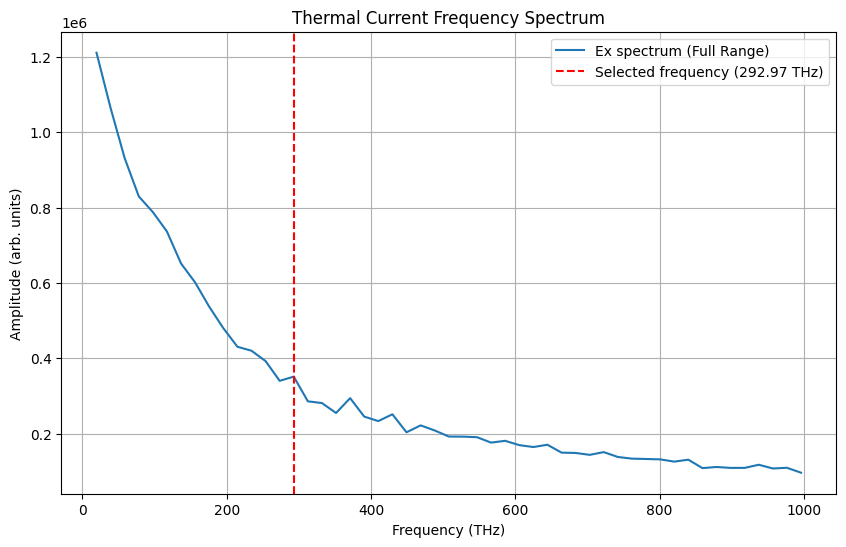

Simulation size: (5.0, 5.0, 5.0) μm
Grid resolution: <bound method GridSpec._dl_min of GridSpec(attrs={}, grid_x=UniformGrid(attrs={}, type='UniformGrid', dl=0.1), grid_y=UniformGrid(attrs={}, type='UniformGrid', dl=0.1), grid_z=UniformGrid(attrs={}, type='UniformGrid', dl=0.1), wavelength=None, override_structures=(), snapping_points=(), layer_refinement_specs=(), type='GridSpec')> μm
------------------------------


In [99]:

plt.figure(figsize=(10, 6))
# Plotting with frequencies in THz for better human readability
plt.plot(thermal_current_dataset_full.Ex.f.values / 1e12, np.mean(np.abs(thermal_current_dataset_full.Ex.values), axis=(0,1,2)), label='Ex spectrum (Full Range)')
plt.axvline(x=single_freq_frequencies_hz[0] / 1e12, color='r', linestyle='--', label=f'Selected frequency ({single_freq_frequencies_hz[0]/1e12:.2f} THz)')
plt.xlabel('Frequency (THz)')
plt.ylabel('Amplitude (arb. units)')
plt.title('Thermal Current Frequency Spectrum')
plt.legend()
plt.grid(True)
plt.show()
plt.close() # Close the figure to free up memory

# --- 9. Example Simulation Setup ---
sim = td.Simulation(
    size=(5, 5, 5),
    grid_spec=td.GridSpec.uniform(dl=0.1),
    structures=[],
    sources=[thermal_custom_source],
    monitors=[],
    run_time=1e-12, # seconds
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML())
)

print(f"Simulation size: {sim.size} μm")
print(f"Grid resolution: {sim.grid_spec._dl_min} μm") # FIX: Corrected attribute name
print("-" * 30)